# Compute summary statistics of LST and NDVI

## Introduction

Having computed LST and NDVI across NYC, we now compute summary statistics within HOLC grades. We compute 

- mean
- median
- minimum
- maximum
- standard deviation

of the LST and NDVI within every HOLC boundary and save the results to a CSV file.

- In [Section 1](#summary-calc), we compute these summary statistics and save them to a file. 
- In [Section 2](#agg-calc), we compute the mean of these summary statistics grouped by borough and grade and export them to an aggregated statistics file. 
- In [Section 3](#heatmap) we plot the summary statistics for a particular Landsat file and HOLC boundary. 
- In [Section 4](#boundary-plot) we plot the HOLC boundaries by borough. 

## Results

Summary statistics are computed and exported to the `02-data/` folder. 

## Data

Two types of data are imported: (i) raster data, which comes from LST and NDVI computations obtained from Landsat and (ii) shapefiles specifying HOLC boundaries. All files are imported and exported from the `02-data/` directory. Shapefiles are imported from `boundaries/holc_nyc/` and LST/NDVI files are imported from `lst_clipped_nyc/`/`ndvi_clipped_nyc`.

Summary statistics are exported as CSV files to two different directories. First, summary statistics for every LST/NDVI file containing information for every HOLC boundary is exported to `summary_stats/`. The number of files in this folder should match the total sum of files in `lst_clipped_nyc/` and `ndvi_clipped_nyc`. Then the results are aggregated and exported to `summary_stats_agg/`.

In [2]:
import os
DIR_PARENT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
DIR_SCRIPTS = DIR_PARENT + "/01-scripts"

"""Push directory to helper scripts from"""
import sys
sys.path.append(DIR_SCRIPTS)

import helpers

import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
import numpy as np

# For plotting
import matplotlib.pyplot as plt

DIR_DATA = DIR_PARENT + "/02-data"

DIR_STATS = DIR_DATA + "/summary_stats"
DIR_STATS_AGG = DIR_DATA + "/summary_stats_agg"

DIR_BOUNDARIES = DIR_DATA + "/boundaries"
DIR_BOUNDARIES_HOLC = DIR_BOUNDARIES + "/holc_nyc"

# Export directories
DIR_NDVI_CLIPPED_NYC = DIR_PARENT + "/02-data/ndvi_clipped_nyc"
DIR_LST_CLIPPED_NYC = DIR_PARENT + "/02-data/lst_clipped_nyc"
DIR_FIGS = DIR_PARENT + "/03-figs"

keys_stats = ["median","mean","min","max","std"]

def compute_stats(clipped_file):
    stats = {"median": clipped_file.median().values,
            "mean": clipped_file.mean().values,
            "min": clipped_file.min().values,
            "max": clipped_file.max().values,
            "std": clipped_file.std().values}
    return stats

def get_row_df(df, row_loc):
    return df[df.index==row_loc]

## 1. Compute summary statistics for every HOLC file <a id="summary-calc"></a>

For every clipped LST/NDVI file, we clip to each HOLC boundary and save the summary statistics for every boundary as a row in a pandas dataframe. The exported file has the form outlined in the table below. 

| holc_id | holc_grade | geometry | loc_year | median | mean | min | max | std |
|---------|------------|----------|----------|--------|------|-----|-----|-----|
| "boundary_id_from_source_file" | "holc_grade" | holc_polygon | "boro_identifier" | median_pixel | mean_pixel | min_pixel | max_pixel | std_pixel |
| $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |$\vdots$ |$\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |

NOTE: The export process takes a few hours. It would be great to make this more efficient. Maybe there's a way to parallellize, since I'm not sure how the clipping function can be made better. 

In [3]:
"""Get all the clipped LST and NDVI filenames
Calling get_filenames twice compiles all the filenames to one list."""
clipped_filenames = []
helpers.get_filenames(DIR_LST_CLIPPED_NYC, clipped_filenames)
helpers.get_filenames(DIR_NDVI_CLIPPED_NYC, clipped_filenames)

"""Get the CRS from landsat"""
crs_landsat = rxr.open_rasterio(clipped_filenames[0], 
                                masked=True).rio.crs

"""Get all filenames of HOLC shapefiles"""
shapefile_names_holc = []
helpers.get_filenames(DIR_BOUNDARIES_HOLC, shapefile_names_holc)
shapefile_names_holc = [x for x in shapefile_names_holc if ".shp" in x]

"""Initialize a dataframe to store all the HOLC information"""
df_holc = gpd.read_file(shapefile_names_holc[0])
df_holc = df_holc.to_crs(crs_landsat)
df_holc["loc_year"] = shapefile_names_holc[0].split("/")[-2]
print(shapefile_names_holc[0].split("/")[-2], ", ", len(df_holc))

for fn in shapefile_names_holc[1:]:
    df = gpd.read_file(fn)
    df = df.to_crs(crs_landsat)
    boro_year = fn.split("/")[-2]
    df["loc_year"] = boro_year
    print(boro_year, ", Number of boundaries = ", len(df))
    df_holc = df_holc.append(df)

df_holc.reset_index(inplace=True)

print("\nNumber of LST and NDVI files = ",len(clipped_filenames))

NYStatenIsland1940 ,  66
NYManhattan1937 , Number of boundaries =  53
NYBronx1938 , Number of boundaries =  44
NYQueens1938 , Number of boundaries =  168
NYBrooklyn1938 , Number of boundaries =  66

Number of LST and NDVI files =  229


In [5]:
df_holc[df_holc["holc_grade"]=="E"] # Not sure what this is 

,index,name,holc_id,holc_grade,geometry,loc_year
162,43,None,E1,E,"POLYGON ((596046.892 4522070.547, 596050.225 4...",NYBronx1938


**!! NOTE !!** The following cell takes a few hours to run. If you already have already computed statistics for every landsat file, skip to the next cell. 

In [7]:
for fn in clipped_filenames:
    
    """Initialize a DF for the HOLC data and summary statistics"""
    df_holc_stats = df_holc.copy()
    df_holc_stats[keys_stats] = 0.0

    for index in range(len(df_holc)):
        # For every HOLC polygon, clip clip the input data and compute 
        # statistic
        boundary_holc = get_row_df(df_holc,index)["geometry"]
        
        # Import the data that you will clip. This is either LST or NDVI data. 
        clipped = helpers.open_and_clip(fn, boundary_holc)

        # ! IMPORTANT ! All values exactly equal to 0.0 are outside of 
        # the boundary. All values equal to -9999.0 were masked by the 
        # USGS. Must mask the dataframe in order for statistics to be 
        # accurate.
        clipped_masked = clipped.where(clipped != -0.0) 
        clipped_masked = clipped_masked.where(clipped_masked != -9999.0) 

        df_holc_stats.loc[index,keys_stats] = compute_stats(
                clipped_masked).values()
    
    exportname = DIR_STATS + "/stats_" + fn.split("/")[-1].split(".")[0] + ".csv"
    df_holc_stats = pd.DataFrame(df_holc_stats)
    print("Saving ",exportname)
    df_holc_stats.to_csv(exportname, index=False)    
   

Saving  /home/aderrasc/Documents/japa_final/02-data/summary_stats/stats_lst_LC08_L1GT_109212_20150921_20170404_01_T2.csv
Saving  /home/aderrasc/Documents/japa_final/02-data/summary_stats/stats_lst_LC08_L1TP_013032_20140731_20170304_01_T1.csv
Saving  /home/aderrasc/Documents/japa_final/02-data/summary_stats/stats_lst_LC08_L1TP_013032_20140917_20170303_01_T1.csv
Saving  /home/aderrasc/Documents/japa_final/02-data/summary_stats/stats_lst_LC08_L1TP_013032_20150803_20170226_01_T1.csv
Saving  /home/aderrasc/Documents/japa_final/02-data/summary_stats/stats_lst_LC08_L1TP_013032_20160720_20170222_01_T1.csv
Saving  /home/aderrasc/Documents/japa_final/02-data/summary_stats/stats_lst_LC08_L1TP_013032_20160805_20170222_01_T1.csv
Saving  /home/aderrasc/Documents/japa_final/02-data/summary_stats/stats_lst_LC08_L1TP_013032_20170909_20170927_01_T1.csv
Saving  /home/aderrasc/Documents/japa_final/02-data/summary_stats/stats_lst_LC08_L1TP_013032_20180710_20180717_01_T1.csv
Saving  /home/aderrasc/Documents

## 2. Aggregate the statistics <a id="agg-calc"></a>

For LST and NDVI, we compile results into one aggregated dataframe in the following cell. The dataframe has the form 

| source_file | holc_grade | loc_year | median | mean | min | max | std |
|-------------|------------|----------|--------|------|-----|-----|-----|
| "name_of_source_file"| "grade_to_filtery_by" | "boro_to_filter_by" | mean_of_medians | mean_of_mean | mean_of_min | mean_of_max | mean_of_std |
| $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |$\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |

- `source_file` specifies the filename containing summary statistics for a single Landsat file. (These are the file exported in Section 1 of this notebook.) 
- `holc_grade` specifies the selected HOLC elements of `source_file` that are considered in the rest of the row
- `loc_year` specifies the selected location elements of `source_file` that ar considered in the rest of the row
- `median`, `mean`, `min`, `max`, `std` are the means of the elements of `source_file` filtered by `holc_grade` and `loc_year`

For example, a few rows of the aggregate file that compute the summary statistics of LST in the Bronx may look like

| source_file | holc_grade | loc_year | median | mean | min | max | std |
|-------------|------------|----------|--------|------|-----|-----|-----|
| stats_lst_LT05_L1TP_014032_19910621_20160929_01_T1.csv | "A" | "NYBronx1938" | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 |
| stats_lst_LT05_L1TP_014032_19910621_20160929_01_T1.csv | "B" | "NYBronx1938" | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 |
| $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |$\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |

In this way, two aggregate files are generated: one for LST and one for NDVI. They are exported to `02-data/summary_stats_agg/`.

In [4]:
# Get all the summary stats and split into NDVI and LST
summary_names=[]
helpers.get_filenames(DIR_STATS, summary_names)
lst_summary_names = [x for x in summary_names if "lst" in x]
ndvi_summary_names = [x for x in summary_names if "ndvi" in x]


holc_grades = ["A","B","C","D"]
stat_cols = ["median","mean","min","max","std"]
loc_years = ["NYBrooklyn1938","NYBronx1938","NYManhattan1937",
                 "NYStatenIsland1940","NYQueens1938"]

combined_filenames = [lst_summary_names, ndvi_summary_names]
prefix_filenames = ["lst","ndvi"]

count = 0
for filename_list in combined_filenames:
    
    df_all_stats = pd.DataFrame(columns=["source_file","holc_grade",
                        "loc_year","median","mean","min","max","std"])

    for filename in filename_list:

        df_stats = pd.read_csv(filename)

        # Compute the mean of all the summary statistics by HOLC grade
        # city-wide.
        mean_vals_nyc = df_stats.groupby("holc_grade").mean()[stat_cols]
        mean_vals_nyc["source_file"] = filename.split("/")[-1]
        mean_vals_nyc["loc_year"] = "NYC"
        mean_vals_nyc.reset_index(inplace=True)

        df_all_stats = pd.concat([df_all_stats, mean_vals_nyc])

        for grade in holc_grades:
            # Compute the mean of all the summary statistics by HOLC 
            # grade by borough.
            mean_vals_boros = df_stats[df_stats["holc_grade"]==
                            grade].groupby("loc_year").mean()[stat_cols]
            mean_vals_boros["source_file"] = filename.split("/")[-1]
            mean_vals_boros["holc_grade"] = grade
            mean_vals_boros.reset_index(inplace=True)

            df_all_stats = pd.concat([df_all_stats, mean_vals_boros])

    df_all_stats.to_csv(DIR_STATS_AGG + "/"+prefix_filenames[count]+
                        "_mean_stats_combined.csv")
    count+=1


## 3. Plot the LST/NDVI for a single HOLC boundary <a id=heatmap></a>

/home/aderrasc/Documents/japa_final/02-data/lst_clipped_nyc/lst_LT05_L1TP_013032_19850901_20161004_01_T1
350    NYBrooklyn1938
Name: loc_year, dtype: object


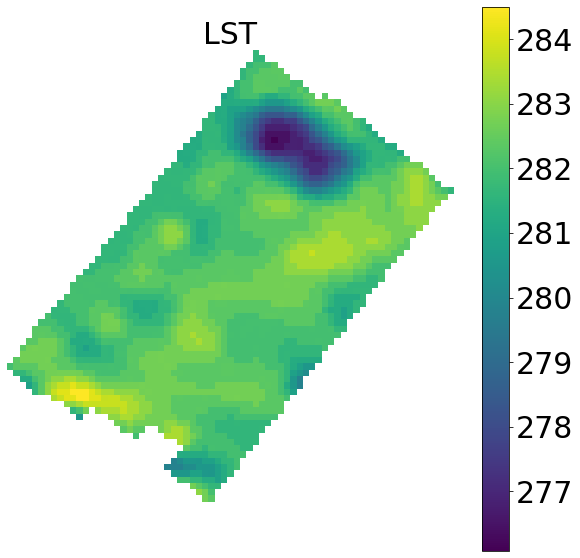

In [5]:
filename = clipped_filenames[1]
boundary_index = 350 # OPTIONS: Integer between 0 and 396

######################################################################
boundary_holc = get_row_df(df_holc,boundary_index)["geometry"]
print(filename)
print(get_row_df(df_holc,boundary_index)["loc_year"])

# Import the data that you will clip. This is either LST or NDVI data. 
clipped = helpers.open_and_clip(filename, boundary_holc)
clipped_masked = clipped.where(clipped != -0.0) 
clipped_masked = clipped_masked.where(clipped_masked != -9999.0) 

fig = plt.figure(figsize=(10, 10))

plt.imshow(clipped_masked.squeeze())

cbar = plt.colorbar()
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(30)
plt.axis('off')
plt.title("LST", fontsize=30)

plt.savefig(DIR_FIGS + "/holc_clip_lst_example.png")    
plt.show()

## 4. Plot all HOLC boundaries <a id="boundary-plot"></a>

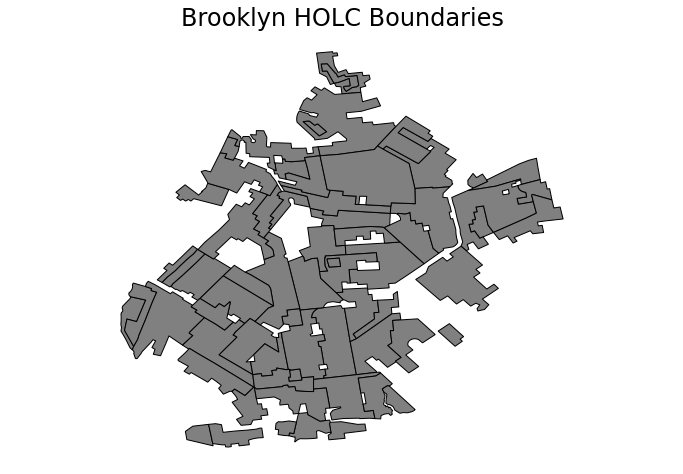

In [10]:
# Import the boundary file
boundary_grade = gpd.read_file(shapefile_names_holc[4])

# Plot the data
fig, ax = plt.subplots(figsize = (12,8))
boundary_grade.plot(ax = ax, facecolor = 'gray', edgecolor = 'black')

# Add title to map
plt.title("Brooklyn HOLC Boundaries", fontsize=24)

# Turn off the axis  
plt.axis('equal')
ax.set_axis_off()

plt.savefig(DIR_FIGS + "/brooklyn_example.png")

plt.show()